In [1]:
%env CLEARML_WEB_HOST=https://app.clear.ml
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=PJ8BTJI54MKLA5REBTR4
%env CLEARML_API_SECRET_KEY=gd9TZxNe2fPhdsSjE10Fo1PT4NjP0twKoQa3mJMH5p8VPVbFxV

env: CLEARML_WEB_HOST=https://app.clear.ml
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=PJ8BTJI54MKLA5REBTR4
env: CLEARML_API_SECRET_KEY=gd9TZxNe2fPhdsSjE10Fo1PT4NjP0twKoQa3mJMH5p8VPVbFxV


Импортируем библиотеки 

In [2]:
import tensorflow as tf
tf.keras.datasets.mnist.load_data(path="mnist.npz")
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt 
import numpy as np
from tensorflow.keras.utils import to_categorical
from clearml import Task, Logger

Чтобы начать работать с ClearML инициируем новую сессию

In [3]:
task = Task.init(
    project_name='mnist_classifier', 
    task_name='cnn_model', 
    output_uri=True)

ClearML Task: overwriting (reusing) task id=2c6dba6813c54b238c053e003ce58e0f
2023-12-29 23:18:07,127 - clearml.Task - INFO - No repository found, storing script code instead
ClearML results page: https://app.clear.ml/projects/d0467c5bdc9f4ca79df56e62873329ff/experiments/2c6dba6813c54b238c053e003ce58e0f/output/log
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start


Загрузка и предобработка данных. Изменяем размерность массива, чтобы соответствовать ожидаемому формату входных данных модели. Приводим к вещественному типу данных. Номализуем значений пикселей в диапазоне [0,1] . Преобразования меток классов в формат one-hot encoding

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape((60000, 28, 28, 1)).astype('float32') / 255
x_test = x_test.reshape((10000, 28, 28, 1)).astype('float32') / 255
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Создаем CNN модель. 

In [5]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

2023-12-29 23:19:50.512448: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-12-29 23:19:50.512515: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pl): /proc/driver/nvidia/version does not exist
2023-12-29 23:19:50.514240: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Настраиваем модель перед началом обучения. Выбрала "Adam", т.к. это популярный и эффективный оптимизатор, который сочетает в себе методы градиентного спуска и стохастического градиентного спуска. "Categorical crossentropy" эта функция потерь определяет, как измеряется разница между предсказанными и истинными значениями. Используется в задачах многоклассовой классификации, когда каждый пример может принадлежать только к одному классу. Аccuracy - метрика, которая будет отслеживаться в процессе обучения

In [6]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Обучаем модель

In [7]:
history = model.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=0.2)


Epoch 1/5
750/750 [==============================] - 15s 20ms/step - loss: 0.2159 - accuracy: 0.9343 - val_loss: 0.0722 - val_accuracy: 0.9777
Epoch 2/5
750/750 [==============================] - 14s 18ms/step - loss: 0.0605 - accuracy: 0.9809 - val_loss: 0.0553 - val_accuracy: 0.9847
Epoch 3/5
750/750 [==============================] - 14s 18ms/step - loss: 0.0435 - accuracy: 0.9860 - val_loss: 0.0466 - val_accuracy: 0.9872
Epoch 4/5
750/750 [==============================] - 14s 18ms/step - loss: 0.0324 - accuracy: 0.9904 - val_loss: 0.0456 - val_accuracy: 0.9857
Epoch 5/5
750/750 [==============================] - 13s 18ms/step - loss: 0.0270 - accuracy: 0.9915 - val_loss: 0.0680 - val_accuracy: 0.9799


Оцениваем точность обученной модели на тестовых данных

In [8]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc}')

313/313 [==============================] - 1s 4ms/step - loss: 0.0620 - accuracy: 0.9799
Test accuracy: 0.9799000024795532


Получаем значения потерь и точности из истории обучения

In [9]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

Строим и отображаем график потерь и точности

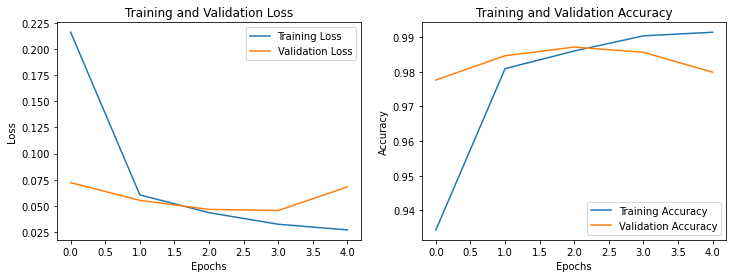

In [10]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Построим график точности
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Отобразим графики
plt.show()

Получаем предсказания модели на тестовых данных и выбираем 50 рандомных значений из теста

In [11]:
predictions = model.predict(x_test)

# Выберем случайные изображения из тестового набора
num_images_to_show = 50
random_indices = np.random.choice(x_test.shape[0], num_images_to_show, replace=False)

313/313 [==============================] - 1s 3ms/step


Отображаем изображения, значения и предсказания модели

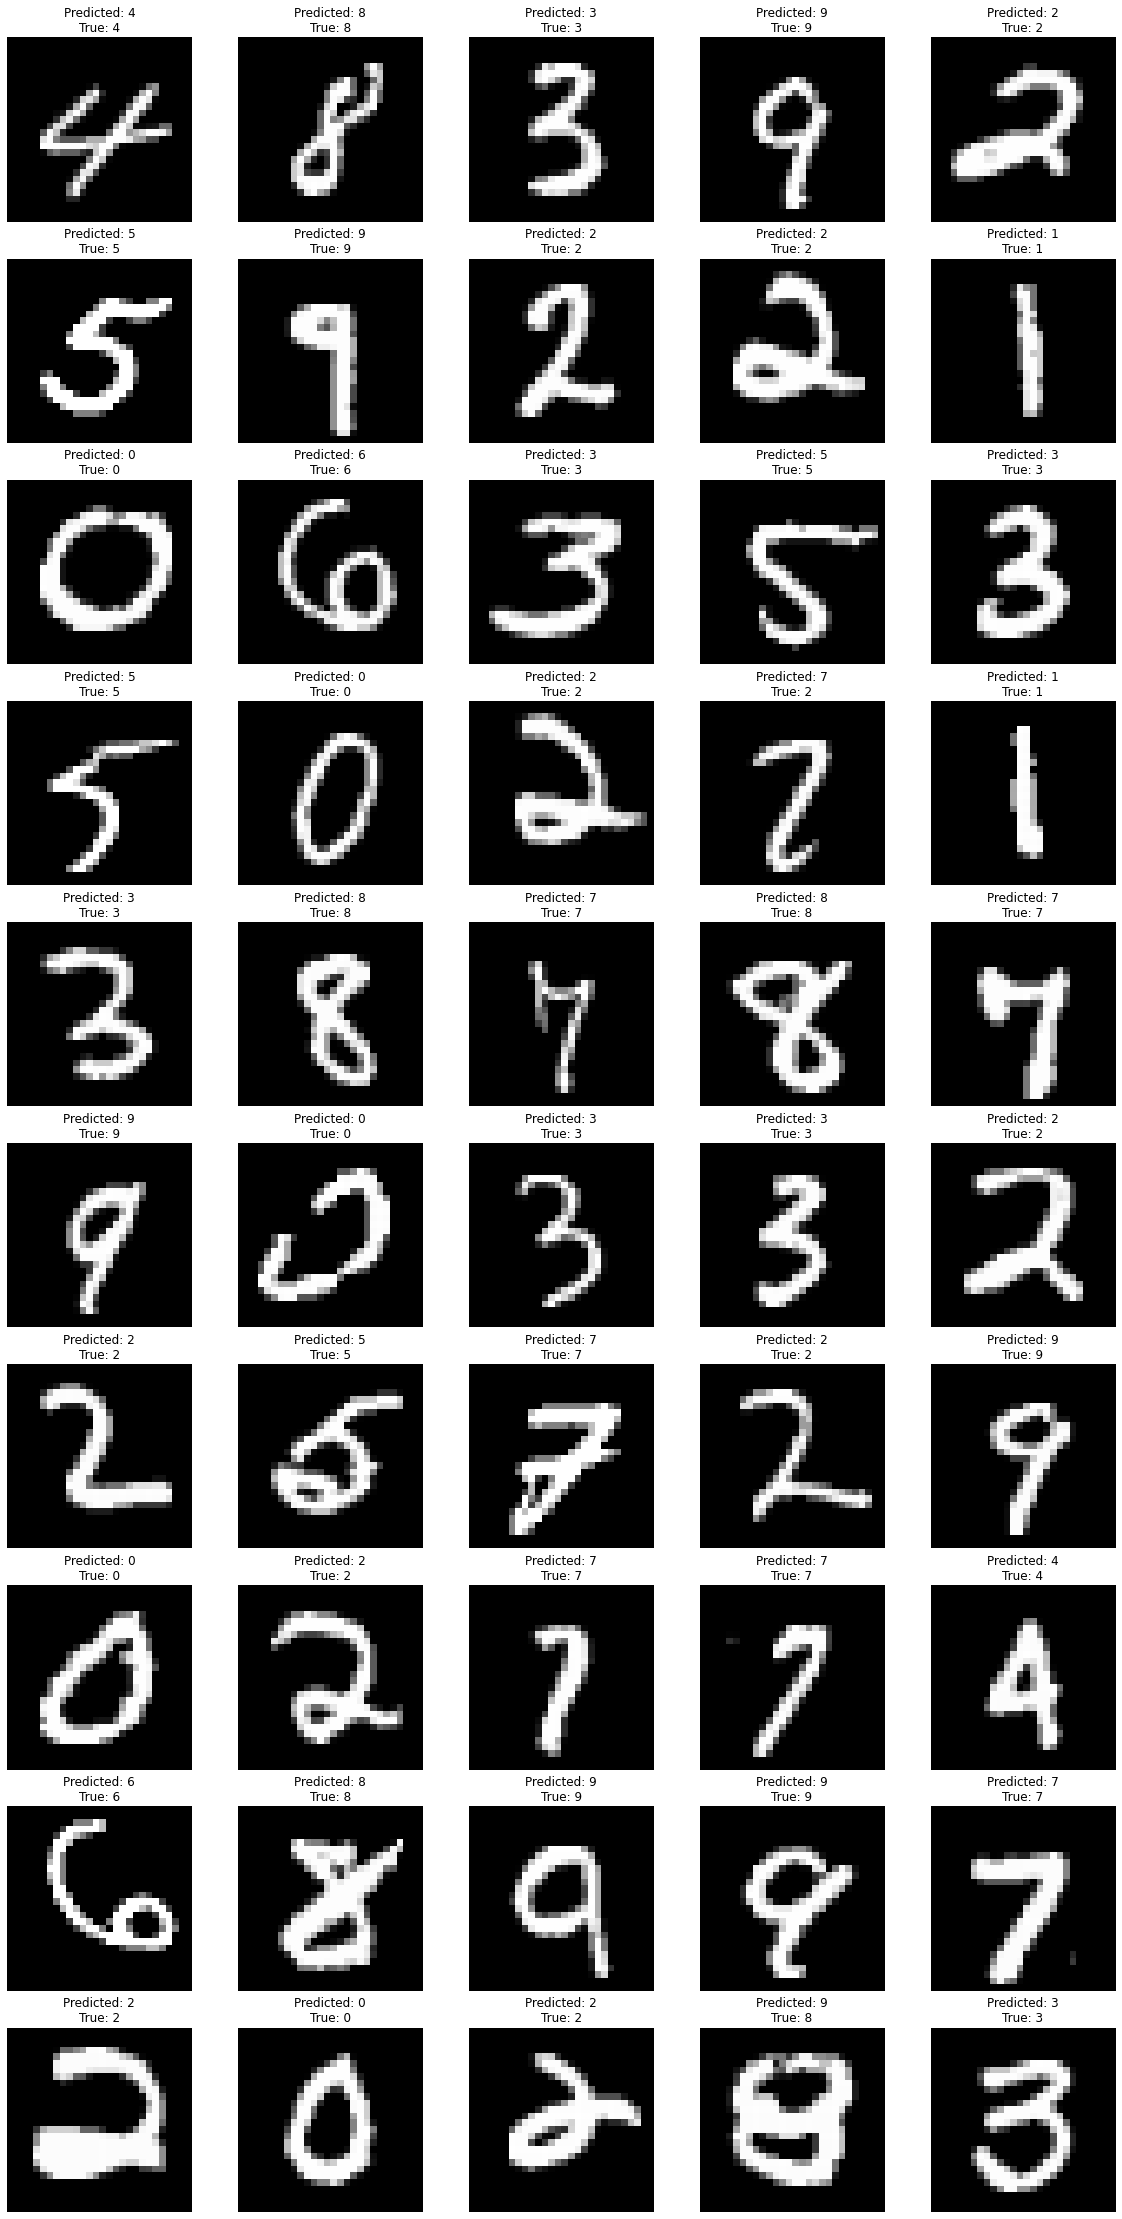

In [12]:
plt.figure(figsize=(20, 40))
for i, index in enumerate(random_indices, 1):
    plt.subplot(10, 5, i)
    plt.imshow(x_test[index].reshape(28, 28), cmap='gray')
    plt.title(f'Predicted: {np.argmax(predictions[index])}\nTrue: {np.argmax(y_test[index])}')
    plt.axis('off')

plt.show()

Сохраняем модель для дальнейшей работы в Clearml

In [13]:
model.save('/home/pl/Documents/mnist_classifier/')

INFO:tensorflow:Assets written to: /home/pl/Documents/mnist_classifier/assets


INFO:tensorflow:Assets written to: /home/pl/Documents/mnist_classifier/assets


2023-12-29 23:26:39,966 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/mnist_classifier/cnn_model.2c6dba6813c54b238c053e003ce58e0f/models/mnist_classifier.zip


In [14]:
task.close()